In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [138]:
zori_new = pd.read_csv('./data/ZRI Data.csv')

In [139]:
zori_new.shape

(3264, 86)

In [140]:
zori_new.groupby('msa_name')[['region_id']].count().reset_index().sort_values(by='region_id',ascending=False).head()

,msa_name,region_id
50,"Los Angeles-Long Beach-Anaheim, CA",240
61,"New York, NY",200
55,"Miami-Fort Lauderdale, FL",158
98,"Washington, DC",135
18,"Chicago, IL",134


In [141]:
zori_new['region_name'] = zori_new['region_name'].astype('str')
zori_new['region_name'] = zori_new['region_name'].apply(lambda x: x.zfill(5))

In [142]:
zori_raw = pd.read_csv('./data/Zip_Zri_AllHomesPlusMultifamily.csv')

In [143]:
zori_raw.shape

(13181, 120)

In [144]:
zori_raw['RegionName'] = zori_raw['RegionName'].astype('str')
zori_raw['RegionName'] = zori_raw['RegionName'].apply(lambda x: x.zfill(5))

### Data set: ZRI of all homes plus Multi-family house type

- Include all type of house, so it can be a more comprehensive representation of the rental market
- More refined granularity(Metro, city and state level)

In [147]:
zori_raw.shape

(13181, 120)

In [148]:
zori_raw.iloc[:,:5].nunique()

RegionID      13181
RegionName    13181
City           6730
State            51
Metro           773
dtype: int64

### Granularity: Metro level 

- real-life impact
- medium level of granularity, not too refined, not too aggragated
* some of the zipcodes are not associated to any metro area (9.4%)

In [149]:
metro_zipcode = zori_raw.groupby('Metro')[['RegionID']].count().reset_index()

In [150]:
metro_zipcode.sort_values(by='RegionID', ascending=False).head(15)

,Metro,RegionID
487,New York-Newark-Jersey City,724
405,Los Angeles-Long Beach-Anaheim,342
135,Chicago-Naperville-Elgin,306
538,Philadelphia-Camden-Wilmington,271
85,Boston-Cambridge-Newton,233
738,Washington-Arlington-Alexandria,228
174,Dallas-Fort Worth-Arlington,225
317,Houston-The Woodlands-Sugar Land,187
186,Detroit-Warren-Dearborn,181
37,Atlanta-Sandy Springs-Roswell,175


In [151]:
zori_raw.groupby('City')[['RegionID']].count().sort_values(by='RegionID', ascending=False).head(10)

,RegionID
City,
New York,157
Los Angeles,96
Houston,91
Chicago,54
San Antonio,50
Phoenix,46
Philadelphia,46
Austin,43
Dallas,42


In [154]:
metro_zipcode.RegionID.describe()

count    773.000000
mean      15.450194
std       41.482803
min        1.000000
25%        2.000000
50%        5.000000
75%       11.000000
max      724.000000
Name: RegionID, dtype: float64

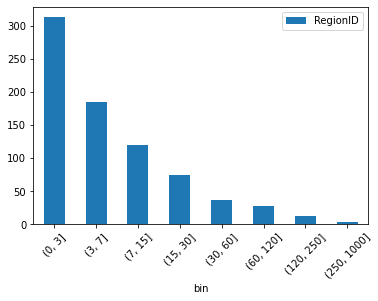

In [155]:
metro_zipcode['bin'] = pd.cut(metro_zipcode['RegionID'],[0,3,7,15,30,60,120,250,1000])
metro_zipcode.groupby('bin')[['RegionID']].count().reset_index().plot(x='bin',kind='bar',rot=45)

In [156]:
zori_raw.loc[zori_raw['Metro'].isnull(),'Metro'] = 'No-Metro'

In [157]:
top10_metro = metro_zipcode.sort_values(by='RegionID', ascending=False).head(10)['Metro']

Further analysis and modeling will be applied on zipcodes from the top 10 metro areas in United States.

In [158]:
zori_metro10 = zori_raw.loc[zori_raw['Metro'].isin(top10_metro),:]

Save a file of the zipcode-metro mapping for data filtering in other data resources.

In [145]:
focus_zipcode = zori_raw.loc[zori_raw['Metro'].isin(top10_metro),['RegionName','Metro']]
# focus_zipcode.to_csv('focus_zipcode.csv', index=False)

### Target: ZRI from Jan, 2019 to Dec, 2019

- __Top 10 Metro areas (2872 zipcodes) --- greater market value__
- proportionally sample ~100 metro area/2000 zipcodes --- better representative
- Or all zipcode --- computation burden

- __Use 2019 data instead 2020 data to avoid the influence of pandemic__

### Missing Data

In [159]:
zori_metro10.isnull().sum()/zori_metro10.shape[0]

RegionID      0.000000
RegionName    0.000000
City          0.000000
State         0.000000
Metro         0.000000
CountyName    0.000000
SizeRank      0.000000
2010-09       0.100279
2010-10       0.192897
2010-11       0.104109
2010-12       0.119777
2011-01       0.111769
2011-02       0.102368
2011-03       0.093315
2011-04       0.075209
2011-05       0.063370
2011-06       0.062674
2011-07       0.067549
2011-08       0.068245
2011-09       0.076602
2011-10       0.080084
2011-11       0.074861
2011-12       0.072423
2012-01       0.068593
2012-02       0.059540
2012-03       0.053621
2012-04       0.051880
2012-05       0.061978
2012-06       0.066156
2012-07       0.068593
2012-08       0.065460
2012-09       0.056755
2012-10       0.056058
2012-11       0.059889
2012-12       0.051880
2013-01       0.055014
2013-02       0.054318
2013-03       0.055014
2013-04       0.053273
2013-05       0.066504
2013-06       0.068593
2013-07       0.074513
2013-08       0.071379
2013-09    

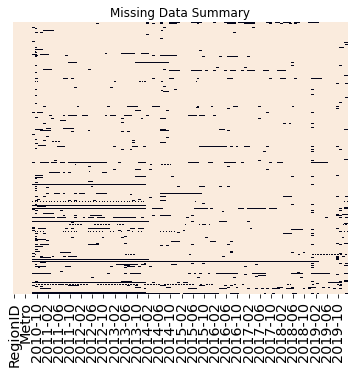

In [160]:
plt.figure(figsize = (6,5))
df_null = zori_metro10.isnull()
sns.heatmap(~df_null, cbar=False, yticklabels = False)
plt.xticks(rotation = 90, size = 'x-large')
plt.title('Missing Data Summary')
# plt.savefig('missing.png',dpt=300)
plt.show()

Long horizontal line indicates the zipcode is associated with a lot of continuously missing data. It seems a lot of those type of missingness happened before 2014. In our analysis, we are more interested in the years between 2014-2020, so we will only keep the data of those years. However, to facilitate the missing data interpolation in the next step, we will also include 2012, 2013 data in this step.

In [161]:
column_dic = {}
for i in range(len(zori_metro10.columns)):
    column_dic[zori_metro10.columns[i]] = i

In [162]:
zori_2012 = zori_metro10.iloc[:,list(range(7))+list(range(23,120))]

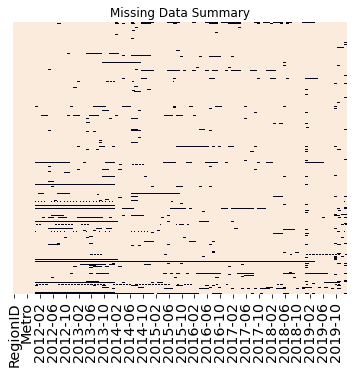

In [163]:
plt.figure(figsize = (6,5))
df_null = zori_2012.isnull()
sns.heatmap(~df_null, cbar=False, yticklabels = False)
plt.xticks(rotation = 90, size = 'x-large')
plt.title('Missing Data Summary')
# plt.savefig('missing.png',dpt=300)
plt.show()

For better model preformance, we will exclude zipcodes that have more than 50% missing data points.

In [164]:
zori_clean = zori_2012[~(zori_2012.iloc[:,7:].isnull().sum(axis=1)/len(zori_2012.iloc[:,7:].columns) >= 0.50)]
zori_clean.shape

(2839, 104)

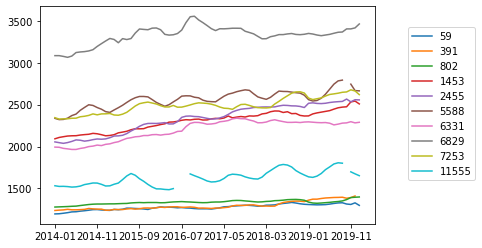

In [44]:
sample = np.random.choice(zori_clean.index,10,replace=False)
zori_clean[zori_clean.index.isin(sample)].iloc[:,7:].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.2), loc=8, borderaxespad=0.)

In [46]:
zori_clean[zori_clean.index == 11555]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
11555,61167,08751,Ortley Beach,NJ,New York-Newark-Jersey City,Ocean County,11556,1532.0,1524.0,1525.0,1522.0,1516.0,1519.0,1528.0,1546.0,1555.0,1565.0,1564.0,1549.0,1529.0,1531.0,1550.0,1564.0,1605.0,1649.0,1678.0,1657.0,1616.0,1585.0,1548.0,1517.0,1495.0,1494.0,1488.0,1485.0,1498.0,NaN,NaN,NaN,1673.0,1652.0,1633.0,1612.0,1589.0,1577.0,1580.0,1592.0,1619.0,1657.0,1670.0,1666.0,1658.0,1638.0,1624.0,1615.0,1612.0,1635.0,1681.0,1713.0,1746.0,1776.0,1786.0,1779.0,1756.0,1713.0,1684.0,1660.0,1638.0,1632.0,1647.0,1678.0,1724.0,1757.0,1792.0,1806.0,1801.0,NaN,1698.0,1674.0,1652.0


To recover the rent changing trend, we will interpolate missing data with 'linear' methods. 
For example, in the above sample record indexed 11555, there is missingness between 2016-06 ~ 2016-08. Then missing ZRIs will be filled as: 

                                        (1673 - 1498)/4 = 44 
                                        1498 + 44 = 1542  --- 2016-06
                                        1542 + 44 = 1586  --- 2016-07
                                        1586 + 44 = 1630  --- 2016-08

In [165]:
zori_clean2 = zori_clean.copy()

In [166]:
zori_clean2.iloc[:,7:] = round(zori_clean2.iloc[:,7:].interpolate(method='linear',axis=1),1)

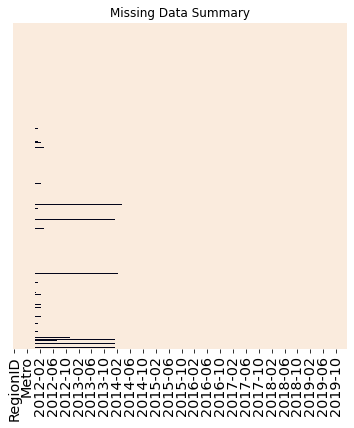

In [167]:
plt.figure(figsize = (6,6))
df_null = zori_clean2.isnull()
sns.heatmap(~df_null, cbar=False, yticklabels = False)
plt.xticks(rotation = 90, size = 'x-large')
plt.title('Missing Data Summary')
# plt.savefig('missing.png',dpt=300)
plt.show()

We only need the data after 2014.

In [168]:
column_dic2 = {}
for i in range(len(zori_clean2.columns)):
    column_dic2[zori_clean2.columns[i]] = i

In [169]:
zori_clean3 = zori_clean2.iloc[:,list(range(7))+list(range(31,104))]

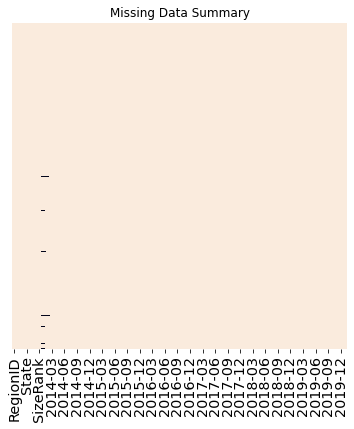

In [170]:
plt.figure(figsize = (6,6))
df_null = zori_clean3.isnull()
sns.heatmap(~df_null, cbar=False, yticklabels = False)
plt.xticks(rotation = 90, size = 'x-large')
plt.title('Missing Data Summary')
# plt.savefig('missing.png',dpt=300)
plt.show()

In [172]:
zori_clean3.isnull().sum()[zori_clean3.isnull().sum()>0]

2014-01    59
2014-02    23
2014-03     3
dtype: int64

There is still some missing data in 2014-01 to 2014-03. Since the proportion is small, we can use back fill method to fill in the NA values.

In [173]:
zori_clean3.iloc[:,7:] = zori_clean3.iloc[:,7:].fillna(method='bfill')

C:\Users\Chun\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [174]:
zori_clean3['2014-01'][zori_clean3['2014-01'].isnull()] = 1137.0
zori_clean3['2014-02'][zori_clean3['2014-02'].isnull()] = 1137.0

<ipython-input-174-51d9823863bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zori_clean3['2014-01'][zori_clean3['2014-01'].isnull()] = 1137.0
C:\Users\Chun\anaconda3\lib\site-packages\pandas\core\generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-174-51d9823863bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zori_clean3['2014-02'][zori_clean3['2014-02'].isnull()] = 1137

In [175]:
zori_clean3.isnull().sum()[zori_clean3.isnull().sum()>0]

Series([], dtype: int64)

After cleaning, the missing data only exist in the early years. For our model, we will only use data after year 2016, so we will not fill in the missing data in earlier time.

In [177]:
zori_clean3.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,3267.0,3285.0,3234.0,3296.0,3357.0,3366.0,3276.0,3186.0,3204.0,3323.5,3443.0,3562.5,3682.0,3767.0,3767.0,3811.0,3793.0,3894.0,3919.0,3968.4,4017.8,4067.2,4116.6,4166.0,4164.0,4133.0,4015.0,3943.0,3945.0,4051.0,4224.0,4397.0,4570.0,4743.0,4916.0,4962.5,5009.0,4804.8,4600.6,4396.4,4192.2,3988.0,3879.0,3770.0,3661.0,3631.2,3601.4,3571.6,3541.8,3512.0,3552.0,3660.0,3768.0,3731.0,3634.0,3522.7,3411.3,3300.0,3227.0,3338.6,3450.2,3561.8,3673.4,3785.0,3788.0,3786.0,3784.0,3766.0,3779.0,3843.0,3873.0,3835.0,3835.0
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,1979.0,1976.0,1969.0,1989.0,1996.0,2001.0,2006.0,2009.0,2032.0,2045.0,2038.0,2028.0,2016.0,2028.0,2033.0,2027.0,2041.0,2071.0,2100.0,2136.0,2139.0,2119.0,2093.0,2079.0,2061.0,2058.0,2079.0,2100.0,2115.0,2150.0,2184.0,2201.0,2212.0,2207.0,2182.0,2136.0,2108.0,2104.0,2117.0,2118.0,2125.0,2146.0,2168.0,2183.0,2165.0,2128.0,2097.0,2070.0,2057.0,2052.0,2054.0,2061.0,2074.0,2106.0,2134.0,2146.0,2155.0,2149.0,2116.0,2076.0,2025.0,2014.0,2017.0,2039.0,2070.0,2105.0,2140.0,2168.0,2185.0,2125.0,2089.0,2053.0,1996.0
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,3357.0,3363.0,3287.0,3312.0,3385.0,3385.0,3308.0,3231.0,3258.0,3408.6,3559.2,3709.8,3860.4,4011.0,3985.0,4026.0,4012.0,4115.1,4218.3,4321.4,4424.6,4527.7,4630.9,4734.0,4800.0,4690.0,4693.0,4555.5,4418.0,4534.0,4643.5,4753.0,4687.0,4788.0,4711.5,4635.0,4558.5,4482.0,4405.5,4329.0,4252.5,4176.0,4086.5,3997.0,3924.0,3899.6,3875.2,3850.8,3826.4,3802.0,3809.0,3900.0,3999.0,4043.0,3957.0,3841.7,3726.3,3611.0,3560.0,3652.0,3744.0,3836.0,3928.0,3874.0,3898.0,3917.0,3929.0,3931.0,3963.0,4043.0,4123.0,4079.0,4079.0
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,1930.0,1936.0,1931.0,1925.0,1929.0,1935.0,1953.0,1967.0,1984.0,1994.0,1999.0,1999.0,1945.0,1917.0,1906.0,1903.0,1908.0,1919.0,1933.0,1944.0,1931.0,1924.0,1918.0,1915.0,1881.0,1859.0,1839.0,1828.0,1827.0,1826.0,1830.0,1826.0,1801.0,1782.0,1772.0,1767.0,1765.0,1763.0,1762.0,1760.0,1752.0,1753.0,1757.0,1763.0,1777.0,1791.0,1799.0,1799.0,1796.0,1791.0,1791.0,1789.0,1787.0,1790.0,1795.0,1790.0,1787.0,1782.0,1779.0,1781.0,1774.0,1773.0,1769.0,1765.0,1755.0,1751.0,1752.0,1754.0,1759.0,1764.0,1769.0,1776.0,1778.0
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,2169.0,2156.0,2145.0,2167.0,2182.0,2191.0,2204.0,2222.0,2247.0,2253.0,2254.0,2241.0,2227.0,2232.0,2233.0,2219.0,2230.0,2262.0,2291.0,2331.0,2338.0,2318.0,2293.0,2278.0,2255.0,2265.0,2291.0,2312.0,2330.0,2356.0,2386.0,2405.0,2421.0,2413.0,2382.0,2342.0,2313.0,2307.0,2319.0,2325.0,2338.0,2364.0,2389.0,2401.0,2391.0,2364.0,2327.0,2290.0,2277.0,2282.0,2290.0,2306.0,2312.0,2333.0,2358.0,2353.0,2360.0,2344.0,2296.0,2260.0,2204.0,2199.0,2213.0,2245.0,2289.0,2332.0,2372.0,2398.0,2412.0,2348.0,2356.0,2311.0,2311.0


In [181]:
zori_compare = zori_clean.iloc[:,list(range(7))+list(range(31,103))]

In [183]:
zori_analysis = zori_clean3.copy()

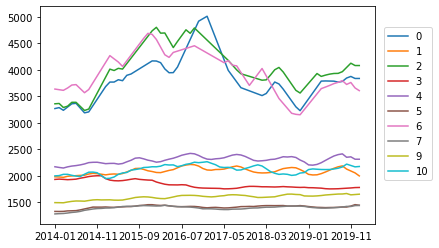

In [184]:
zori_analysis.iloc[:10,7:].T.plot()
plt.legend(bbox_to_anchor=(1.1, 0.2), loc=8, borderaxespad=0.)

Among the top 10 zipcodes, New York area has the biggest fluctuation in price. The other zipcodes rental price stay relatively constant across years.

In [185]:
year_month = ['2014-01','2014-02','2014-03','2014-04','2014-05','2014-06','2014-07','2014-08','2014-09','2014-10',
              '2014-11','2014-12','2015-01','2015-02','2015-03','2015-04','2015-05','2015-06','2015-07','2015-08',
              '2015-09','2015-10','2015-11','2015-12','2016-01','2016-02','2016-03','2016-04','2016-05','2016-06',
              '2016-07','2016-08','2016-09','2016-10','2016-11','2016-12','2017-01','2017-02','2017-03','2017-04',
              '2017-05','2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12','2018-01','2018-02',
              '2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12',
              '2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10',
              '2019-11','2019-12','2020-01']

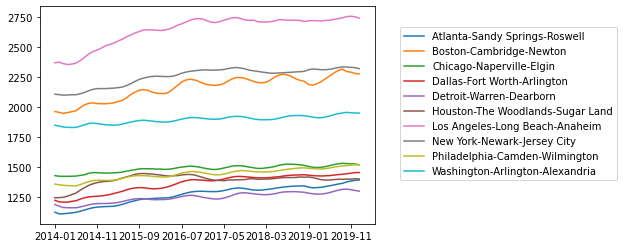

In [186]:
zori_analysis[zori_analysis['Metro'].isin(top10_metro)].groupby('Metro')[year_month].mean().T.plot()
plt.legend(bbox_to_anchor=(1.4, 0.2), loc=8, borderaxespad=0.)

From the top 10 metro area rental price trend plot, we can see a clear seasonality pattern. And the fluctuation in price of certain zipcodes is smoothed by taking area avreage.

In [201]:
zori_analysis[zori_analysis['Metro'] == 'New York-Newark-Jersey City'].head(10)['RegionName']

0     10025
2     10023
6     10002
10    11226
11    10467
14    10016
17    11201
18    11235
19    11375
23    10029
Name: RegionName, dtype: object

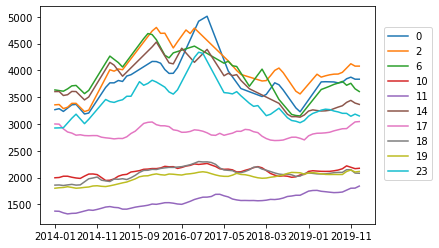

In [188]:
zori_analysis[zori_analysis['Metro'] == 'New York-Newark-Jersey City'].iloc[:10,7:].T.plot()
plt.legend(bbox_to_anchor=(1.1, 0.2), loc=8, borderaxespad=0.)

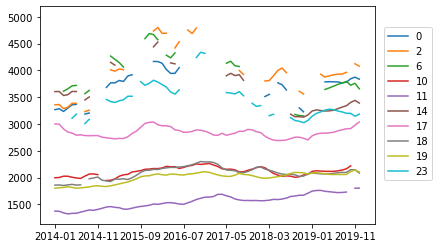

In [189]:
zori_compare[zori_compare['Metro'] == 'New York-Newark-Jersey City'].iloc[:10,7:].T.plot()
plt.legend(bbox_to_anchor=(1.1, 0.2), loc=8, borderaxespad=0.)

Again, zipcodes in New York City show bigger fluctuation in price. None of the other 9 major areas has a sub-zipcode show the same pattern. New York City rental market is very different from anywhere else. In addition, the data quality of New York City zipcode is not as good as elsewhere.

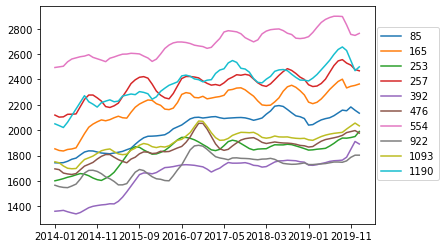

In [190]:
zori_analysis[zori_analysis['Metro'] == 'Boston-Cambridge-Newton'].iloc[:10,7:].T.plot()
plt.legend(bbox_to_anchor=(1.1, 0.2), loc=8, borderaxespad=0.)

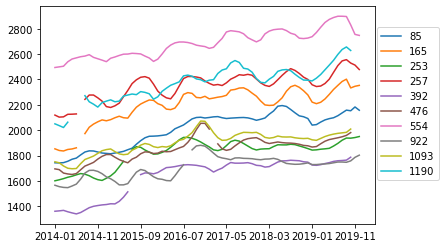

In [191]:
zori_compare[zori_compare['Metro'] == 'Boston-Cambridge-Newton'].iloc[:10,7:].T.plot()
plt.legend(bbox_to_anchor=(1.1, 0.2), loc=8, borderaxespad=0.)

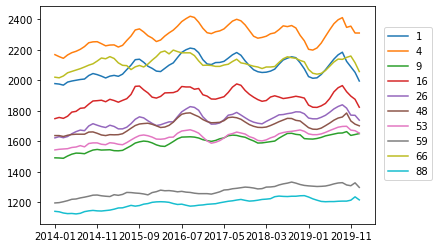

In [192]:
zori_analysis[zori_analysis['Metro'] == 'Chicago-Naperville-Elgin'].iloc[:10,7:].T.plot()
plt.legend(bbox_to_anchor=(1.1, 0.2), loc=8, borderaxespad=0.)

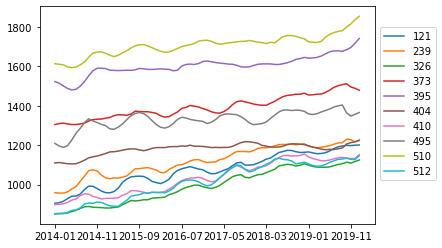

In [193]:
zori_analysis[zori_analysis['Metro'] == 'Philadelphia-Camden-Wilmington'].iloc[:10,7:].T.plot()
plt.legend(bbox_to_anchor=(1.1, 0.2), loc=8, borderaxespad=0.)

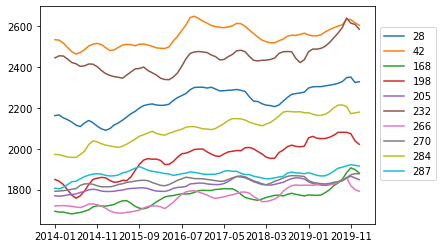

In [194]:
zori_analysis[zori_analysis['Metro'] == 'Washington-Arlington-Alexandria'].iloc[:10,7:].T.plot()
plt.legend(bbox_to_anchor=(1.1, 0.2), loc=8, borderaxespad=0.)

Colder metro areas may have a more significant seasonal pattern. 

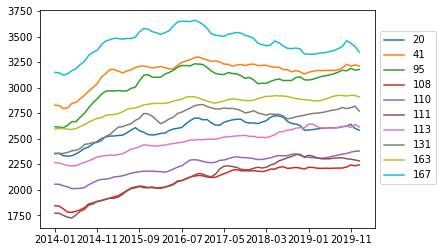

In [195]:
zori_analysis[zori_analysis['Metro'] == 'Los Angeles-Long Beach-Anaheim'].iloc[:10,7:].T.plot()
plt.legend(bbox_to_anchor=(1.1, 0.2), loc=8, borderaxespad=0.)

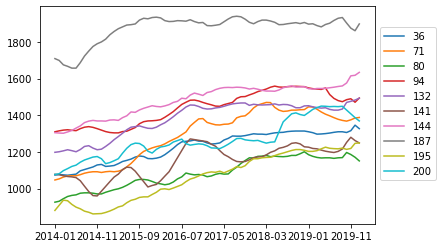

In [196]:
zori_analysis[zori_analysis['Metro'] == 'Dallas-Fort Worth-Arlington'].iloc[:10,7:].T.plot()
plt.legend(bbox_to_anchor=(1.1, 0.2), loc=8, borderaxespad=0.)

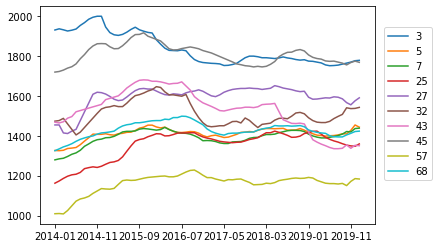

In [197]:
zori_analysis[zori_analysis['Metro'] == 'Houston-The Woodlands-Sugar Land'].iloc[:10,7:].T.plot()
plt.legend(bbox_to_anchor=(1.1, 0.2), loc=8, borderaxespad=0.)

In [200]:
zori_analysis[zori_analysis['Metro'] == 'Detroit-Warren-Dearborn'].head(10)[['RegionName','City','State']]

,RegionName,City,State
154,48180,Taylor,MI
278,48185,Westland,MI
618,48038,Clinton,MI
632,48066,Roseville,MI
738,48187,Canton,MI
789,48228,Detroit,MI
795,48044,Macomb,MI
953,48307,Rochester Hills,MI
981,48219,Detroit,MI
1030,48235,Detroit,MI


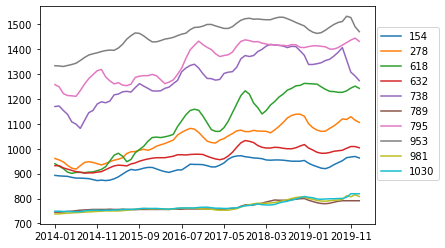

In [199]:
zori_analysis[zori_analysis['Metro'] == 'Detroit-Warren-Dearborn'].iloc[:10,7:].T.plot()
plt.legend(bbox_to_anchor=(1.1, 0.2), loc=8, borderaxespad=0.)

Rent in Clinton, MI has grown roughly 30% from 2014 to 2019.

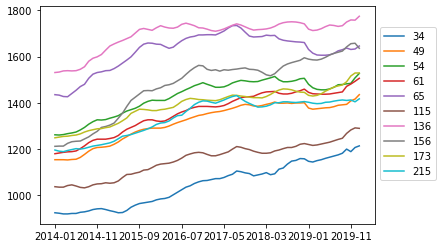

In [202]:
zori_analysis[zori_analysis['Metro'] == 'Atlanta-Sandy Springs-Roswell'].iloc[:10,7:].T.plot()
plt.legend(bbox_to_anchor=(1.1, 0.2), loc=8, borderaxespad=0.)

In [216]:
time_corr = zori_analysis.iloc[:,7:].corr().iloc[-50:-12,-13:]
time_corr.mask(time_corr>=0.99,'0.99+').mask(time_corr<0.99,'less')

,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
2015-12,0.99+,less,less,less,less,0.99+,0.99+,0.99+,0.99+,0.99+,less,less,less
2016-01,less,less,less,less,less,less,0.99+,0.99+,0.99+,less,less,less,less
2016-02,less,less,less,less,less,less,less,less,0.99+,less,less,less,less
2016-03,less,less,less,less,less,less,less,less,less,less,less,less,less
2016-04,less,less,less,less,less,less,less,less,less,less,less,less,less
2016-05,less,less,less,less,less,less,less,less,less,less,less,less,less
2016-06,less,less,less,less,less,0.99+,0.99+,0.99+,0.99+,0.99+,less,less,less
2016-07,0.99+,less,less,less,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,less
2016-08,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+
2016-09,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+,0.99+


In [260]:
column_dic3 = {}
for i in range(len(zori_analysis.columns)):
    column_dic3[zori_analysis.columns[i]] = i

In [252]:
month0 = zori_analysis.iloc[:,list(range(19,79))].columns.tolist()
month1 = zori_analysis.iloc[:,list(range(18,78))].columns.tolist()
month2 = zori_analysis.iloc[:,list(range(17,77))].columns.tolist()
month3 = zori_analysis.iloc[:,list(range(16,76))].columns.tolist()
month6 = zori_analysis.iloc[:,list(range(13,73))].columns.tolist()
month12 = zori_analysis.iloc[:,list(range(7,67))].columns.tolist()

In [251]:
metro10 = pd.melt(zori_analysis,id_vars=['RegionName','Metro'],value_vars=month0[::-1])
month_lag1 = pd.melt(zori_analysis,id_vars=['RegionName'],value_vars=month1[::-1])
month_lag2 = pd.melt(zori_analysis,id_vars=['RegionName'],value_vars=month2[::-1])
month_lag3 = pd.melt(zori_analysis,id_vars=['RegionName'],value_vars=month3[::-1])
month_lag6 = pd.melt(zori_analysis,id_vars=['RegionName'],value_vars=month6[::-1])
month_lag12 = pd.melt(zori_analysis,id_vars=['RegionName'],value_vars=month12[::-1])

In [258]:
timelag_corr = pd.concat([metro10, month_lag1[['value']],month_lag2[['value']],
                         month_lag3[['value']],month_lag6[['value']],month_lag12[['value']]],axis=1)

In [259]:
timelag_corr[3:].corr()

,value,value,value,value,value,value
value,1.000000,0.999744,0.999129,0.998294,0.995450,0.991019
value,0.999744,1.000000,0.999748,0.999140,0.996373,0.991741
value,0.999129,0.999748,1.000000,0.999753,0.997347,0.992445
value,0.998294,0.999140,0.999753,1.000000,0.998303,0.993164
value,0.995450,0.996373,0.997347,0.998303,1.000000,0.995604
value,0.991019,0.991741,0.992445,0.993164,0.995604,1.000000


The correlation coefficient decrease slightly as lag time ranges between 1 month, 2 month, 3 month, 6 month, and 12 month. Depending on how soon we can have access to the new data, and how far we want to make prediction, we can choose the predicting variables accordingly. The smaller the gap is, the higher correlation is, though the difference is not big even after 12 months.

In [233]:
timelag_corr

,RegionName,Metro,variable,value,value,value,value,value,value
0,10025,New York-Newark-Jersey City,2019-12,3835.0,3873.0,3843.0,3779.0,3784.0,3338.6
1,60657,Chicago-Naperville-Elgin,2019-12,2053.0,2089.0,2125.0,2185.0,2140.0,2076.0
2,10023,New York-Newark-Jersey City,2019-12,4079.0,4123.0,4043.0,3963.0,3929.0,3652.0
3,77494,Houston-The Woodlands-Sugar Land,2019-12,1776.0,1769.0,1764.0,1759.0,1752.0,1781.0
4,60614,Chicago-Naperville-Elgin,2019-12,2311.0,2356.0,2348.0,2412.0,2372.0,2260.0
...,...,...,...,...,...,...,...,...,...
170335,11569,New York-Newark-Jersey City,2015-01,2387.0,2390.0,2395.0,2412.0,2418.0,1499.0
170336,08740,New York-Newark-Jersey City,2015-01,1484.0,1493.0,1500.0,1510.0,1517.0,1499.0
170337,18464,New York-Newark-Jersey City,2015-01,1180.0,1184.0,1177.0,1161.0,1139.0,1932.0
170338,60602,Chicago-Naperville-Elgin,2015-01,2008.0,2016.0,1998.0,1983.0,1967.0,1932.0


In [273]:
import re
zri_final = timelag_corr.copy()
zri_final['Year'] = zri_final['variable'].map(lambda x:re.search('(\d+)-',x).group(1))
zri_final['Month'] = zri_final['variable'].map(lambda x:re.search('-(\d+)',x).group(1))

In [274]:
zri_final.drop('variable',axis=1,inplace=True)
zri_final['index'] = zri_final['Year'].astype(str) + '-' + zri_final['RegionName']
zri_final = zri_final.iloc[:,[10,9,1,2,7]]

In [276]:
zri_final.columns = ['index','Month','Metro','ZRI','ZRI_1yr_ago']

In [277]:
zri_final.head()

,index,Month,Metro,ZRI,ZRI_1yr_ago
0,2019-10025,12,New York-Newark-Jersey City,3835.0,3338.6
1,2019-60657,12,Chicago-Naperville-Elgin,2053.0,2076.0
2,2019-10023,12,New York-Newark-Jersey City,4079.0,3652.0
3,2019-77494,12,Houston-The Woodlands-Sugar Land,1776.0,1781.0
4,2019-60614,12,Chicago-Naperville-Elgin,2311.0,2260.0
